In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import color, transform

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from torchvision import datasets

from IPython.display import clear_output

/home/arthur/miniconda3/envs/tl-gpu/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Parameters

In [2]:
batch_size = 64

folder_mnist = "/home/arthur/datasets/mnist"
folder_svhn = "/home/arthur/datasets/svhn"
download_svhn = False # mnist is automatically downloaded if not in the folder

colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

dropout_keep_prob = 0.5

## Create the dataset

In [3]:
def normalize(x, max_value):
    """ If x takes its values between 0 and max_value, normalize it between -1 and 1"""
    return (x / float(max_value)) * 2 - 1

### SVHN

We follow the methodology of [1] and use the "extra" SVHN set as the training set. The test set can be useful for evaluations beyond the paper.

Concerning the transformation, we turn the 32x32 RGB images to grayscale and normalize them between -1 and 1

In [4]:
svhn_train = datasets.SVHN(root=folder_svhn, download=download_svhn, split="extra")
svhn_test = datasets.SVHN(root=folder_svhn, download=download_svhn, split="test")

In [5]:
def transform_svhn(X):
    X = np.transpose(X, (0,2,3,1))
    X = normalize(X, 256)
    X = X.reshape(len(X), 32, 32, 3)
    
    return X

In [6]:
print("Transforming SVHN train...")
X_svhn_train = transform_svhn(svhn_train.data)

print("Transforming SVHN test...")
X_svhn_test = transform_svhn(svhn_test.data)

Transforming SVHN train...
Transforming SVHN test...


In [7]:
lb_svhn = LabelBinarizer()

Y_svhn_train = lb_svhn.fit_transform(svhn_train.labels.flatten() % 10)
Y_svhn_test = svhn_test.labels.flatten() % 10

### MNIST

Resize 28x28 grayscale images to 32x32 grayscale images

In [8]:
mnist = input_data.read_data_sets(folder_mnist, one_hot=False)

Extracting /home/arthur/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [9]:
def transform_mnist(X):
    X = X.reshape(len(X), 28, 28)
    X = np.array([color.gray2rgb(transform.resize(im, [32,32])) for im in X])
    X = normalize(X, 1)
    X = X.reshape(len(X), 32, 32, 3)
    
    return X

In [10]:
print("Transforming MNIST train...")
X_mnist_train = transform_mnist(mnist.train.images)

print("Transforming MNIST test...")
X_mnist_test = transform_mnist(mnist.test.images)

Transforming MNIST train...


/home/arthur/miniconda3/envs/tl-gpu/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Transforming MNIST test...


In [11]:
lb_mnist = LabelBinarizer()

Y_mnist_train = lb_mnist.fit_transform(mnist.train.labels)
Y_mnist_test = mnist.test.labels

### Source and target

In [12]:
X_source = X_svhn_train
Y_source = Y_svhn_train
X_source_test = X_svhn_test
Y_source_test = Y_svhn_test

X_target = X_mnist_train
X_target_test = X_mnist_test
Y_target_test = Y_mnist_test

## Create the model

In [13]:
tf.reset_default_graph()

### Useful functions

In [14]:
def leaky_relu(x):
    alpha = 0.05
    return tf.maximum(x, alpha * x)

### Placeholders

In [16]:
ipt_source = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='ipt_source')
ipt_target = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='ipt_target')
labels_source = tf.placeholder(tf.int32, shape=[None, 10], name="labels_source")
keep_prob = tf.placeholder_with_default(1., shape=[], name="keep_prob")

### Encoder network

In [17]:
def encoder(x):
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE): # shared weights
        # Layer 1: 32x32x1 --> 16x16x64
        conv1 = tf.layers.conv2d(x, 100, [5, 5], strides=2, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv1 = tf.layers.batch_normalization(conv1)

        # Layer 2: 16x16x64 --> 8x8x128
        conv2 = tf.layers.conv2d(conv1, 200, [5, 5], strides=2, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv2 = tf.layers.batch_normalization(conv2)

        # Layer 3: 8x8x128 --> 1x1x256
        conv3 = tf.layers.conv2d(conv2, 400, [8, 8], strides=1, padding='VALID', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv3 = tf.layers.batch_normalization(conv3)

        # Layer 4: 1x1x256 --> 1x1x512
        conv4 = tf.layers.conv2d(conv3, 800, [1, 1], strides=1, padding='VALID', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv4 = tf.layers.batch_normalization(conv4)

        # Layer 5 : 1x1x512 --> 1x1x1024
        mu = tf.layers.conv2d(conv4, 800, [1, 1], strides=1, padding='SAME', 
                              kernel_initializer=initializer, activation=None)
        
    return mu

In [18]:
def generator(z):
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE): # shared weights
        # Layer 1: 8x8x1024 --> 8x8x512
        deconv1 = tf.layers.conv2d_transpose(z, 800, [4, 4], strides=2, padding='VALID', kernel_initializer=initializer, activation=leaky_relu)
        deconv1 = tf.layers.batch_normalization(deconv1)

        # Layer 2: 8x8x512 --> 16x16x256
        deconv2 = tf.layers.conv2d_transpose(deconv1, 400, [4, 4], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv2 = tf.layers.batch_normalization(deconv2)
        
        # Layer 3: 16x16x256 --> 32x32x512
        deconv3 = tf.layers.conv2d_transpose(deconv2, 200, [4, 4], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv3 = tf.layers.batch_normalization(deconv3)
        
        # Layer 3: 16x16x256 --> 32x32x512
        deconv4 = tf.layers.conv2d_transpose(deconv3, 100, [4, 4], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv4 = tf.layers.batch_normalization(deconv4)
        
        # Layer 6: 16x16x64 --> 32x32x3
        deconv5 = tf.layers.conv2d_transpose(deconv4, 3, [1, 1], strides=1, padding='SAME', kernel_initializer=initializer, activation=tf.nn.tanh)
    
    return deconv5

### Define the graph

In [49]:
# E_mean_target = encoder(ipt_target)
E_mean_source = encoder(ipt_source)

In [50]:
# G_t2t = generator(E_mean_target)
G_s2s = generator(E_mean_source)

### Loss

In [51]:
def reconstruction_loss(x, x_rec):
    return tf.losses.mean_squared_error(x, x_rec)

In [52]:
G_loss = reconstruction_loss(ipt_source, G_s2s)

### Solver

In [53]:
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator') \
         + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')

In [54]:
with tf.variable_scope("optim", reuse=tf.AUTO_REUSE):
    G_solver = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5).minimize(G_loss, var_list=G_vars)

## Run the model

In [55]:
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))

In [56]:
sess.run(tf.global_variables_initializer())
G_loss_list = []
iter_list = []
i = 0

In [68]:
nb_iter = 100000
verbose = True

i_init = i
for i in range(i, nb_iter+i):
    sample_source = X_source[np.random.choice(len(X_source), batch_size)]
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={ipt_source: sample_source})
        
   
    iter_list.append(i)
    G_loss_list.append(G_loss_curr)
    
    if verbose and i % 10 == 0:
        clear_output(wait=True)
        print('Iter: {} / {}'.format(i, i_init + nb_iter - 1))
        print('G loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 2130 / 100924
G loss: 0.007159



KeyboardInterrupt: 

## Display the results

### Image visualization

In [69]:
def unnormalize(x):
    return np.array((x + 1)/2)

In [70]:
X_s2s = unnormalize(sess.run(G_s2s, feed_dict={ipt_source: X_source[:batch_size]}))

(-0.5, 31.5, 31.5, -0.5)

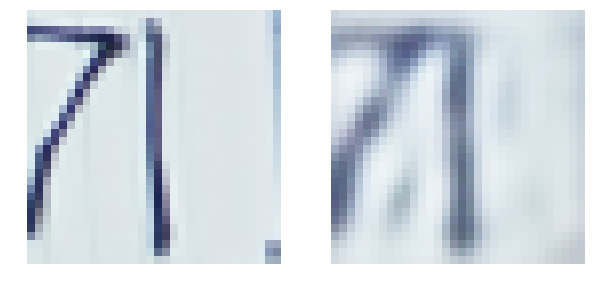

In [71]:
plt.rcParams['figure.figsize'] = (10, 5)
# plt.axes().set_aspect('equal', 'datalim')
#plt.axis([-3,3,-3,3])
index = 4
plt.subplot(1,2,1)
plt.imshow(unnormalize(X_source[index]))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(X_s2s[index])
plt.axis('off')